# Import des outils / jeu de données

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import prince
import seaborn as sns
from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTEN, SMOTENC
from keras import layers
from lightgbm import LGBMClassifier
from sklearn.compose import ColumnTransformer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import IsolationForest, RandomForestClassifier, VotingClassifier
from sklearn.feature_selection import mutual_info_regression
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    make_scorer,
    recall_score,
)
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.naive_bayes import BernoulliNB, ComplementNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    LabelEncoder,
    OneHotEncoder,
    OrdinalEncoder,
    RobustScaler,
    StandardScaler,
)
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from tensorflow import keras
from utils import map3_score, top3_predictions
from xgboost import XGBClassifier

In [17]:
SEED = 0

In [18]:
np.random.seed(SEED)
sns.set_theme()

In [49]:
synthetic_data = pd.read_csv(
    "data/train.csv",
    index_col="id",
)

In [50]:
original_data = pd.read_csv("data/original_dataset_train.csv")

In [51]:
original_data["prognosis"] = original_data["prognosis"].apply(
    lambda x: x.replace(" ", "_")
)

In [52]:
df = pd.concat((synthetic_data, original_data))

## Variables globales

In [58]:
TARGET = "prognosis"
LABELS = df[TARGET].unique()

In [59]:
X = df.copy()
y = X.pop(TARGET)

In [60]:
le = LabelEncoder()
y = le.fit_transform(y)

In [61]:
var_quanti = []

In [62]:
var_quali = X.columns

## Fonctions et variables utiles

In [63]:
score_modeles = []

**Tableau.** Informations sur notre classification

|:---------------------------|:----------------------------------|
| **Objectif métier**        | Prédire l'acceptation à une campagne marketing |
| **Problème technique**     | Classification binaire supervisée |
| **Métrique**               | Score F1 sur la classe 1 (clients qui acceptent)<br>À score F1 égal, on choisit la meilleure précision sur la classe 1 |
| **Méthode d'entraînement** | Validation croisée en 5 blocs     |
| **Pré-traitement**         | Variables quantitatives : centrer/réduire<br>Variables qualitatives : OneHot Encoding (Tableau Disjonctif Complet) |
| **Équilibrage des classes**| 1) Aucun<br>2) Sous-échantillonnage aléatoire manuel<br>3) Sur-échantillonnage avec SMOTE |


In [64]:
def evaluate_models(models, prefix, X_train, X_test, y_train, y_test):
    """Evalue tous les modèles dans `models` et sauvegarde les résultats avec un préfixe `prefix`
    (utile pour distinguer les différentes stratégies de pré-traitement des données)."""
    results = []

    for model_name, model in models.items():
        name = f"{prefix}/{model_name}"
        print(name)

        scores = cross_val_score(
            model,
            X_train,
            y_train,
            cv=5,
            scoring=make_scorer(map3_score, needs_proba=True),
        )

        scores_mean = scores.mean()
        scores_std = scores.std()

        results.append(
            [
                name,
                scores_mean,
                scores_std,
            ]
        )
        score_modeles.extend(
            (
                [
                    name,
                    "score",
                    scores_mean,
                    scores_std,
                ],
            )
        )

    print(sorted(results, key=lambda x: x[1], reverse=True))

    return results

# Liste des modèles

**Tableau.** Liste des modèles de notre étude

|:---------------------------|:----------------------------------|
| **Modèles de référence**   | Classificateur Idiot Uniforme (50% de oui et 50% de non)<br>Classificateur Idiot Constant 1 (100% de oui) |
| **Modèles linéaires**  | Régression logistique<br>Analyse Discriminante Linéaire |
| **Arbres de décision**               | Arbre de décision<br>Forêt d'arbres de décision (Random Forest) |
| **Gradient Boosting** | XGBoost<br>LightGBM<br>CatBoost |
| **Machine à vecteurs de support (SVM)** | Classificateur SVM linéaire |
| **k plus proches voisins (k-NN)** | Classificateur k-nn (5 voisins)<br>Classificateur k-nn (15 voisins) |
| **Modèle de vote**| Modèle de "Vote à la majorité" sur 5 modèles :<br>- Régression logistique<br>- Analyse discriminante linéaire<br>- Random Forest<br>- XGBoost<br>- CatBoost |
| **Réseau de neurones**| Réseau de neurones à 5 couches et 1 600 neurones |


In [65]:
models = {
    "DummyClassifier_Uniform": DummyClassifier(strategy="uniform", random_state=SEED),
    "DummyClassifier_MostFrequent": DummyClassifier(
        strategy="most_frequent", random_state=SEED
    ),
    "KNeighborsClassifier": KNeighborsClassifier(),
    "LinearSVC": LinearSVC(random_state=SEED),
    "LogisticRegression": LogisticRegression(random_state=SEED),
    "LinearDiscriminantAnalysis": LinearDiscriminantAnalysis(),
    "RandomForestClassifier": RandomForestClassifier(random_state=SEED),
    "XGBClassifier": XGBClassifier(random_state=SEED),
    "CatBoostClassifier": CatBoostClassifier(random_state=SEED, verbose=False),
    "LGBMClassifier": LGBMClassifier(random_state=SEED),
}

# Todo

- refactor code
- refactor: include MCA in pipeline
- feature selection
- feature selection: train only on MCA columns? only MCA cols + some selected original variables?
- feature engineering: add clusters to variables
- SMOTE categorical
- code Tetsu https://www.kaggle.com/code/tetsutani/ps3e13-eda-decomposition-ensemble-rankpredict/notebook
- rajouter le temps pris par chaque algo dans la fonction qui évalue les modèles



# Traitement des données

## Pipeline

In [66]:
var_cat_non_ohe = []
var_cat_non_ohe = X.columns

In [67]:
var_cat_ohe = []

In [68]:
quanti_processor = Pipeline(
    steps=[
        ("imputer", SimpleImputer()),
        ("scaler", StandardScaler()),
    ]
)

In [69]:
quali_processor = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        (
            "encoder",
            OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=np.nan),
        ),
    ]
)

In [70]:
preprocessor = ColumnTransformer(
    remainder="passthrough",
    transformers=[
        ("quali_processor", quali_processor, var_quali),
        ("quanti_processor", quanti_processor, var_quanti),
    ],
)

In [71]:
nouveau_df = pd.DataFrame(preprocessor.fit_transform(X), index=df.index)

In [72]:
nouveau_df.shape

(959, 64)

## Par défaut

In [73]:
X_train, X_test, y_train, y_test = train_test_split(
    nouveau_df, y, test_size=0.2, random_state=SEED
)

In [74]:
y_train[:5]

array([1, 2, 8, 3, 4])

In [75]:
nouveau_df.shape

(959, 64)

In [29]:
rf = CatBoostClassifier(random_state=SEED, verbose=False)
rf.fit(X_train, y_train)

In [30]:
y_pred = rf.predict_proba(X_test)

In [31]:
top3_predictions(rf, X_train, le)

/home/ab2/.cache/pypoetry/virtualenvs/kaggle-competitions-ww632Mhq-py3.10/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([['Japanese_encephalitis', 'Tungiasis', 'Rift_Valley_fever'],
       ['Tungiasis', 'West_Nile_fever', 'Rift_Valley_fever'],
       ['Rift_Valley_fever', 'West_Nile_fever', 'Plague'],
       ...,
       ['Plague', 'Yellow_Fever', 'Zika'],
       ['Yellow_Fever', 'Japanese_encephalitis', 'Zika'],
       ['West_Nile_fever', 'Lyme_disease', 'Plague']], dtype=object)

In [32]:
map3_score(y_test, y_pred)

0.35563380281690143

In [76]:
prefix = "défaut"
results = evaluate_models(models, prefix, X_train, X_test, y_train, y_test)

défaut/DummyClassifier_Uniform
défaut/DummyClassifier_MostFrequent
défaut/KNeighborsClassifier
défaut/LinearSVC


/home/ab2/.cache/pypoetry/virtualenvs/kaggle-competitions-ww632Mhq-py3.10/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/ab2/.cache/pypoetry/virtualenvs/kaggle-competitions-ww632Mhq-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/ab2/.cache/pypoetry/virtualenvs/kaggle-competitions-ww632Mhq-py3.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/home/ab2/.cache/pypoetry/virtualenvs/kaggle-competitions-ww632Mhq-py3.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 316, in _score
    y_pred = method_caller(clf, "predict_proba", X)
  File "/home/ab2/.cache/p

défaut/LogisticRegression


/home/ab2/.cache/pypoetry/virtualenvs/kaggle-competitions-ww632Mhq-py3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/ab2/.cache/pypoetry/virtualenvs/kaggle-competitions-ww632Mhq-py3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for

défaut/LinearDiscriminantAnalysis
défaut/RandomForestClassifier
défaut/XGBClassifier
défaut/CatBoostClassifier
défaut/LGBMClassifier
[['défaut/LinearSVC', nan, nan], ['défaut/RandomForestClassifier', 0.452440370087429, 0.032626159175834536], ['défaut/CatBoostClassifier', 0.4474436239142121, 0.02233833439057248], ['défaut/LinearDiscriminantAnalysis', 0.4467546614605438, 0.030900896009844876], ['défaut/LGBMClassifier', 0.4311249752426223, 0.02929960866093552], ['défaut/LogisticRegression', 0.42831678125795775, 0.021640308677191224], ['défaut/XGBClassifier', 0.41830065359477125, 0.02300555927230201], ['défaut/KNeighborsClassifier', 0.3311433664374841, 0.030401508013723204], ['défaut/DummyClassifier_MostFrequent', 0.14428316781257958, 0.0036817783906263907], ['défaut/DummyClassifier_Uniform', 0.08018136547548312, 0.0009395786794193713]]


In [77]:
sorted(results, key=lambda x: x[1], reverse=True)

[['défaut/LinearSVC', nan, nan],
 ['défaut/RandomForestClassifier', 0.452440370087429, 0.032626159175834536],
 ['défaut/CatBoostClassifier', 0.4474436239142121, 0.02233833439057248],
 ['défaut/LinearDiscriminantAnalysis',
  0.4467546614605438,
  0.030900896009844876],
 ['défaut/LGBMClassifier', 0.4311249752426223, 0.02929960866093552],
 ['défaut/LogisticRegression', 0.42831678125795775, 0.021640308677191224],
 ['défaut/XGBClassifier', 0.41830065359477125, 0.02300555927230201],
 ['défaut/KNeighborsClassifier', 0.3311433664374841, 0.030401508013723204],
 ['défaut/DummyClassifier_MostFrequent',
  0.14428316781257958,
  0.0036817783906263907],
 ['défaut/DummyClassifier_Uniform',
  0.08018136547548312,
  0.0009395786794193713]]

In [43]:
raise AssertionError("Nope")

AssertionError: Nope

## Équilibrage des classes

### Under-sampling (manuel)

In [ ]:
# samples0 = df[df["Response"] == 0].sample(350, random_state=SEED)

In [ ]:
# X_eq = pd.concat((samples0, df[df["Response"] == 1]))

In [ ]:
# X_eq["Response"].hist()

In [ ]:
# y_eq = X_eq.pop("Response").astype(int)

In [ ]:
# X_eq = pd.get_dummies(X_eq.drop(columns=["Dt_Customer"]))

In [ ]:
# df["Response"].value_counts()

In [ ]:
NB_A_SUPPRIMER = 1400
drop_indices = np.random.choice(
    nouveau_df[y["Response"] == 0].index, NB_A_SUPPRIMER, replace=False
)
df_subset = nouveau_df.drop(drop_indices)

In [ ]:
y_eq = y.drop(index=drop_indices)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    df_subset, y_eq, test_size=0.2, random_state=SEED
)

In [ ]:
prefix = "éq_classes"
results = evaluate_models(models, prefix, X_train, X_test, y_train, y_test)

In [ ]:
sorted(results, key=lambda x: x[1], reverse=True)

### Over-sampling (SMOTE)

In [ ]:
cat_cols = list(X.select_dtypes(include=["category", "int", "bool"]).columns)

In [ ]:
cat_cols_index = list(map(lambda c: list(X.columns).index(c), cat_cols))

In [ ]:
list(X.iloc[:, cat_cols_index].columns)

In [ ]:
sm = SMOTENC(
    categorical_features=cat_cols_index,
    random_state=SEED,
)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    nouveau_df, y, test_size=0.2, random_state=SEED
)

In [ ]:
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)

In [ ]:
y_train_sm.value_counts(normalize=True)

In [ ]:
prefix = "SMOTE"
results = evaluate_models(models, prefix, X_train_sm, X_test, y_train_sm, y_test)

In [ ]:
sorted(results, key=lambda x: x[1], reverse=True)

# MCA

In [72]:
mca = prince.MCA(
    n_components=df.shape[1],
    random_state=SEED,
)

In [82]:
mca = mca.fit(df)

In [83]:
composantes_acm = mca.row_coordinates(df)
composantes_acm.columns = [f"ACM{i + 1}" for i in range(composantes_acm.shape[1])]

In [84]:
mca.plot(df)

alt.Chart(...)

In [85]:
mca.plot(df, x_component=2, y_component=3)

alt.Chart(...)

In [125]:
composantes_acm.head()

ACM1      ACM2      ACM3      ACM4      ACM5      ACM6      ACM7  \
id                                                                          
249  1.083344  0.042993 -0.570477 -0.632406 -0.252881  0.086794 -0.186027   
522  2.311992 -0.144443 -0.170396 -0.194216  0.351432 -0.174924  0.346761   
313 -0.135507  0.201618 -0.188285 -0.124579  0.212855  0.050981  0.069671   
316  2.200514 -0.481441 -0.461141  0.677949 -0.089145 -0.179004 -0.329192   
652 -0.218195 -0.065770 -0.467255  0.100348  0.300895  0.067813  0.072911   

         ACM8      ACM9     ACM10  ...     ACM54     ACM55     ACM56  \
id                                 ...                                 
249  0.014082  0.330608 -0.101879  ... -0.033553 -0.268968 -0.078654   
522  0.176485 -0.300946  0.443759  ... -0.099805  0.062109  0.221454   
313  0.023380  0.023528  0.044613  ...  0.011560 -0.011783 -0.015828   
316 -0.220420  0.027543 -0.196599  ... -0.092987 -0.277583 -0.080520   
652 -0.371969  0.181857  0.402639  ... -0.161522  0.169869 -0.008109   

        ACM57     ACM58     ACM59     ACM60     ACM61     ACM62     ACM63  
id                                                                         
249  0.133014 -0.188727 -0.019864 -0.108683 -0.076155 -0.084294 -0.080621  
522  0.071475  0.062080  0.001249  0.030215  0.116615 -0.174296  0.244749  
313 -0.008122 -0.138253  0.046844  0.057209  0.033152  0.075285  0.075342  
316 -0.153708  0.251570 -0.251052 -0.236288  0.125572  0.016095 -0.247686  
652 -0.138949  0.007733  0.051095 -0.039276  0.035065 -0.011818  0.015841  

[5 rows x 63 columns]

## Ajout des colonnes ACM

In [91]:
NB_COMP_MCA = 3  # nombre de composantes de l'ACM à garder

In [92]:
mca_comp_to_keep = composantes_acm.iloc[:, :NB_COMP_MCA]

In [103]:
df_mca = pd.concat((nouveau_df, mca_comp_to_keep), axis=1)

In [104]:
df_mca.columns = df_mca.columns.astype(str)

In [105]:
X_train, X_test, y_train, y_test = train_test_split(
    df_mca, y, test_size=0.2, random_state=SEED
)

In [106]:
prefix = "mca"
results = evaluate_models(models, prefix, X_train, X_test, y_train, y_test)

mca/DummyClassifier_Uniform
mca/DummyClassifier_MostFrequent
mca/LogisticRegression


/home/ab2/.cache/pypoetry/virtualenvs/kaggle-competitions-ww632Mhq-py3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/ab2/.cache/pypoetry/virtualenvs/kaggle-competitions-ww632Mhq-py3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for

mca/LinearDiscriminantAnalysis
mca/DecisionTreeClassifier
mca/RandomForestClassifier
mca/XGBClassifier
mca/CatBoostClassifier
mca/LGBMClassifier
mca/LinearSVC


/home/ab2/.cache/pypoetry/virtualenvs/kaggle-competitions-ww632Mhq-py3.10/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/ab2/.cache/pypoetry/virtualenvs/kaggle-competitions-ww632Mhq-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/ab2/.cache/pypoetry/virtualenvs/kaggle-competitions-ww632Mhq-py3.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/home/ab2/.cache/pypoetry/virtualenvs/kaggle-competitions-ww632Mhq-py3.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 316, in _score
    y_pred = method_caller(clf, "predict_proba", X)
  File "/home/ab2/.cache/p

mca/KNeighborsClassifier5
mca/KNeighborsClassifier15
mca/VotingClassifier


/home/ab2/.cache/pypoetry/virtualenvs/kaggle-competitions-ww632Mhq-py3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/ab2/.cache/pypoetry/virtualenvs/kaggle-competitions-ww632Mhq-py3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for

In [107]:
sorted(results, key=lambda x: x[1], reverse=True)

[['mca/XGBClassifier', 0.4374631268436578, 0.02351755920707346],
 ['mca/LGBMClassifier', 0.43215339233038347, 0.04432638054575064],
 ['mca/LinearSVC', nan, nan],
 ['mca/VotingClassifier', 0.43038348082595873, 0.043856678560580065],
 ['mca/CatBoostClassifier', 0.4265486725663717, 0.04715521692233709],
 ['mca/RandomForestClassifier', 0.4094395280235988, 0.02438941192754497],
 ['mca/LinearDiscriminantAnalysis', 0.4047197640117994, 0.04077417555885607],
 ['mca/LogisticRegression', 0.37374631268436576, 0.041346368564927724],
 ['mca/KNeighborsClassifier15', 0.35191740412979344, 0.03524549151915951],
 ['mca/KNeighborsClassifier5', 0.3, 0.03614743051808944],
 ['mca/DecisionTreeClassifier', 0.25722713864306784, 0.020995822595013872],
 ['mca/DummyClassifier_MostFrequent',
  0.16106194690265488,
  0.0014451266919074774],
 ['mca/DummyClassifier_Uniform', 0.07551622418879056, 0.001720044806739029]]

# MCA X_train y_train

In [192]:
X_train, X_test, y_train, y_test = train_test_split(
    nouveau_df, y, test_size=0.2, random_state=SEED
)

In [193]:
mca = prince.MCA(
    n_components=X_train.shape[1],
    random_state=SEED,
)

In [194]:
mca = mca.fit(X_train)

In [195]:
composantes_acm = mca.row_coordinates(X_train)
composantes_acm.columns = [f"ACM{i + 1}" for i in range(composantes_acm.shape[1])]

In [196]:
mca.plot(X_train)

alt.Chart(...)

In [197]:
mca.plot(X_train, x_component=2, y_component=3)

alt.Chart(...)

## Ajout des colonnes ACM

In [198]:
def add_mca_component(data, nb_mca_coord, mca):
    """Return the data concatenated with the `nb_mca_coord` first MCA coordinates.
    `mca` must be the fitted MCA."""
    first_mca_coord = mca.row_coordinates(data).iloc[:, :nb_mca_coord]
    first_mca_coord.columns = [f"MCA{i + 1}" for i in range(first_mca_coord.shape[1])]

    df_mca = pd.concat((data, first_mca_coord), axis=1)
    df_mca.columns = df_mca.columns.astype(
        str
    )  # otherwise it can lead to bug (mixed int/str as column names, which Sklearn does not like)

    return df_mca

In [199]:
X_train_mca = add_mca_component(X_train, 3, mca)
X_test_mca = add_mca_component(X_test, 3, mca)

In [142]:
prefix = "mca"
results = evaluate_models(models, prefix, X_train_mca, X_test_mca, y_train, y_test)

mca/DummyClassifier_Uniform
mca/DummyClassifier_MostFrequent
mca/LogisticRegression


/home/ab2/.cache/pypoetry/virtualenvs/kaggle-competitions-ww632Mhq-py3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/ab2/.cache/pypoetry/virtualenvs/kaggle-competitions-ww632Mhq-py3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for

mca/LinearDiscriminantAnalysis
mca/RandomForestClassifier
mca/XGBClassifier
mca/CatBoostClassifier
mca/LGBMClassifier
mca/VotingClassifier


/home/ab2/.cache/pypoetry/virtualenvs/kaggle-competitions-ww632Mhq-py3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/ab2/.cache/pypoetry/virtualenvs/kaggle-competitions-ww632Mhq-py3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for

In [143]:
sorted(results, key=lambda x: x[1], reverse=True)

[['mca/CatBoostClassifier', 0.35870206489675516, 0.034329997701418674],
 ['mca/VotingClassifier', 0.34778761061946906, 0.030318973823078698],
 ['mca/LinearDiscriminantAnalysis', 0.34424778761061947, 0.047184732748353594],
 ['mca/RandomForestClassifier', 0.34247787610619473, 0.03714237998448696],
 ['mca/XGBClassifier', 0.34129793510324485, 0.029946451688992275],
 ['mca/LGBMClassifier', 0.33539823008849556, 0.0368743362643074],
 ['mca/LogisticRegression', 0.3250737463126844, 0.036147430518089434],
 ['mca/DummyClassifier_MostFrequent',
  0.16106194690265488,
  0.0014451266919074774],
 ['mca/DummyClassifier_Uniform', 0.07551622418879056, 0.001720044806739029]]

# SMOTE

In [271]:
sm = SMOTEN(
    random_state=SEED,
)

In [294]:
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)

In [297]:
X_train_sm.columns = X.columns

In [275]:
prefix = "SMOTE"
results = evaluate_models(models, prefix, X_train_sm, X_test, y_train_sm, y_test)

SMOTE/DummyClassifier_Uniform
SMOTE/DummyClassifier_MostFrequent
SMOTE/LogisticRegression


/home/ab2/.cache/pypoetry/virtualenvs/kaggle-competitions-ww632Mhq-py3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/ab2/.cache/pypoetry/virtualenvs/kaggle-competitions-ww632Mhq-py3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for

SMOTE/LinearDiscriminantAnalysis
SMOTE/RandomForestClassifier
SMOTE/XGBClassifier
SMOTE/CatBoostClassifier
SMOTE/LGBMClassifier


In [277]:
sorted(results, key=lambda x: x[1], reverse=True)

[['SMOTE/CatBoostClassifier', 0.5874747474747475, 0.1333923958564323],
 ['SMOTE/RandomForestClassifier', 0.5793939393939394, 0.09974480241913194],
 ['SMOTE/XGBClassifier', 0.5670707070707071, 0.12363999466510692],
 ['SMOTE/LGBMClassifier', 0.557979797979798, 0.13266068467885772],
 ['SMOTE/LogisticRegression', 0.4971717171717172, 0.11029896022386924],
 ['SMOTE/LinearDiscriminantAnalysis', 0.4870707070707071, 0.10131952606786146],
 ['SMOTE/DummyClassifier_Uniform', 0.07575757575757576, 0.0],
 ['SMOTE/DummyClassifier_MostFrequent', 0.07575757575757576, 0.0]]

# Diagnostic du modèle

## RandomForest feature importance

In [175]:
nom_colonnes = preprocessor.get_feature_names_out(X.columns)

In [176]:
nom_colonnes = list(map(lambda x: x.split("__")[1], nom_colonnes))

In [185]:
nom_colonnes = nom_colonnes + list(df_mca.columns[len(nom_colonnes) :])

In [200]:
model_to_diagnose = models[6][0]

In [208]:
model_to_diagnose.fit(X_train_mca, y_train)

In [209]:
fi = model_to_diagnose.feature_importances_

In [210]:
len(fi)

67

In [211]:
fi = pd.DataFrame(fi.reshape((1, len(fi))), columns=nom_colonnes)

In [212]:
fi = fi.sort_values(
    by=0, axis=1, ascending=False
)  # trier les colonnes en fonction de la ligne 0

<Axes: title={'center': "Importance donnée par le modèle <class 'catboost.core.CatBoostClassifier'>"}>

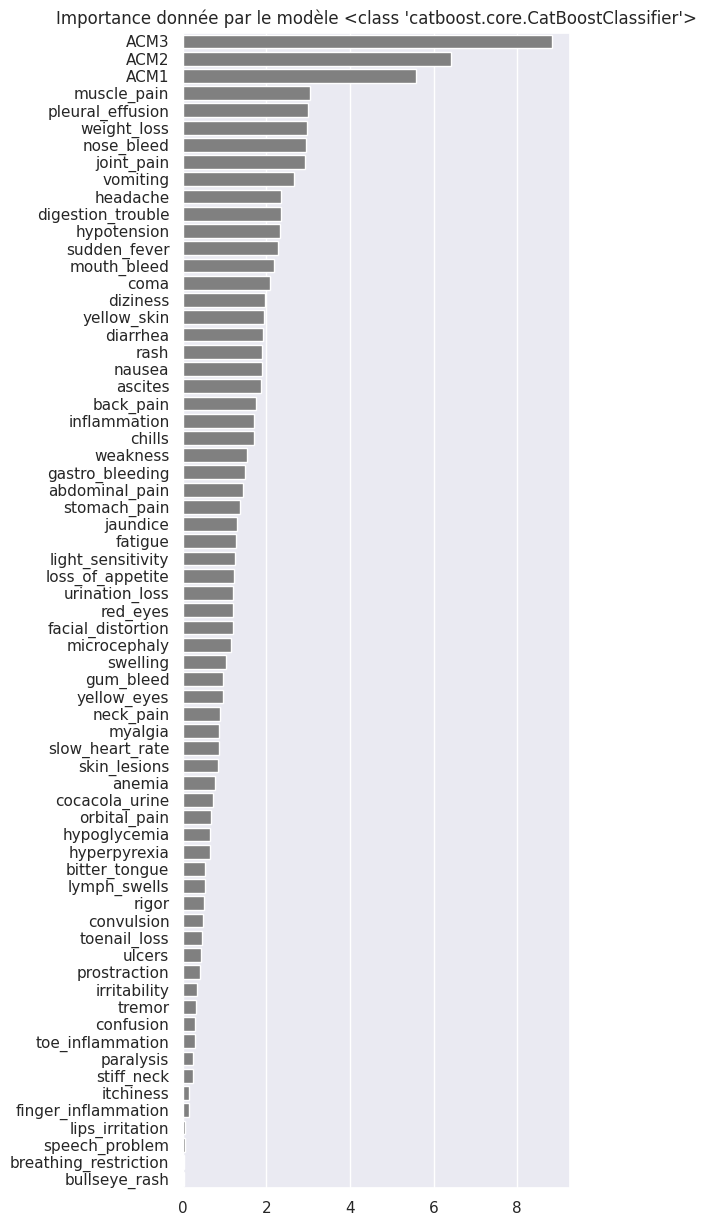

In [268]:
plt.figure(figsize=(5, 15))
plt.title(f"Importance donnée par le modèle {model_to_diagnose.__class__}")
sns.barplot(fi, orient="h", color="gray")

## Permutation importance

In [214]:
result = permutation_importance(
    model_to_diagnose, X_test_mca, y_test, n_repeats=10, random_state=SEED
)

In [ ]:
# sns.histplot(result.importances_std < 0.015)

In [215]:
pi_results = result.importances_mean

In [216]:
pi_results = pd.DataFrame(
    pi_results.reshape((1, len(pi_results))), columns=nom_colonnes
)
pi_results = pi_results.sort_values(by=0, axis=1, ascending=False)

In [235]:
(pi_results.T > 0).index

Index(['ACM3', 'ACM1', 'toenail_loss', 'microcephaly', 'loss_of_appetite',
       'weight_loss', 'diarrhea', 'ulcers', 'itchiness', 'irritability',
       'jaundice', 'anemia', 'digestion_trouble', 'prostraction', 'weakness',
       'back_pain', 'tremor', 'confusion', 'hyperpyrexia', 'nausea', 'myalgia',
       'toe_inflammation', 'breathing_restriction', 'bullseye_rash',
       'pleural_effusion', 'hypoglycemia', 'yellow_skin', 'lips_irritation',
       'speech_problem', 'bitter_tongue', 'inflammation', 'diziness',
       'stiff_neck', 'gastro_bleeding', 'joint_pain', 'vomiting',
       'lymph_swells', 'finger_inflammation', 'rigor', 'facial_distortion',
       'paralysis', 'swelling', 'fatigue', 'ACM2', 'yellow_eyes', 'convulsion',
       'urination_loss', 'light_sensitivity', 'muscle_pain', 'mouth_bleed',
       'rash', 'red_eyes', 'headache', 'cocacola_urine', 'gum_bleed', 'coma',
       'orbital_pain', 'ascites', 'neck_pain', 'sudden_fever', 'stomach_pain',
       'slow_heart_rate

<Axes: title={'center': "Importance de Permutation du modèle <class 'catboost.core.CatBoostClassifier'>"}>

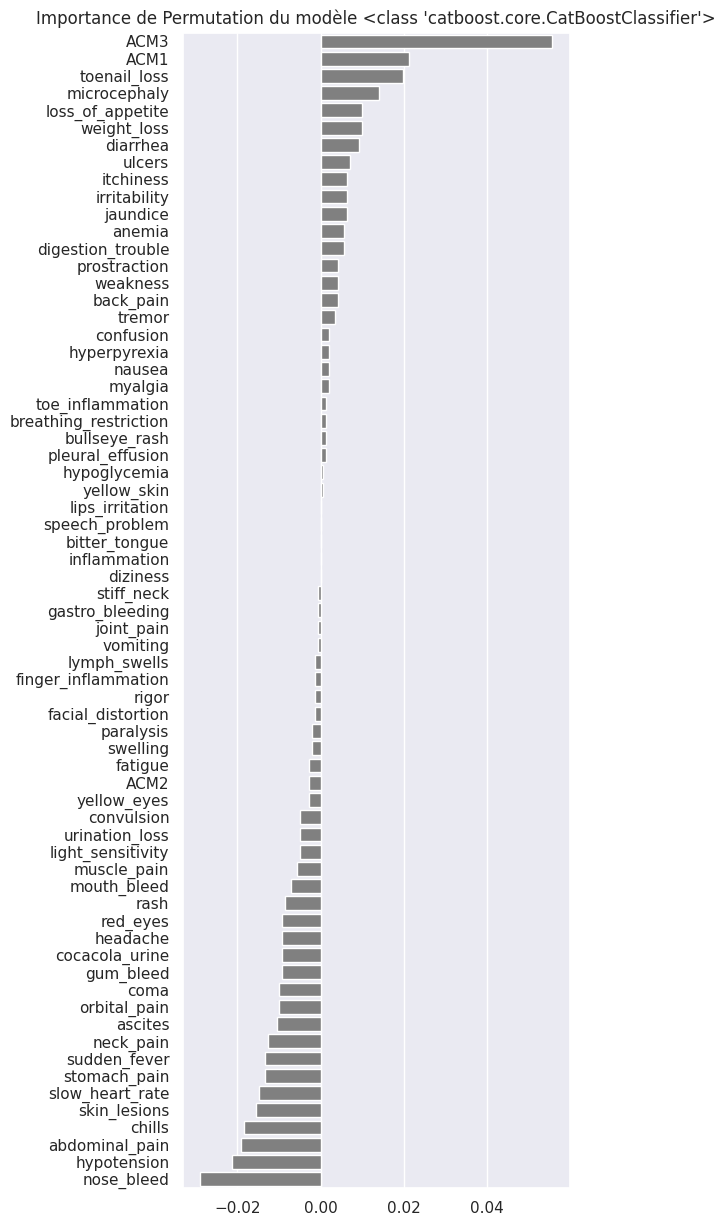

In [219]:
plt.figure(figsize=(5, 15))
plt.title(f"Importance de Permutation du modèle {model_to_diagnose.__class__}")
sns.barplot(pi_results, orient="h", color="gray")

# Feature selection

## Permutation Importance

In [251]:
pi_variables1 = [
    "ACM3",
    "ACM1",
    "toenail_loss",
    "microcephaly",
    "loss_of_appetite",
    "weight_loss",
    "diarrhea",
    "ulcers",
    "itchiness",
    "irritability",
    "jaundice",
    "anemia",
    "digestion_trouble",
    "prostraction",
    "weakness",
    "back_pain",
    "tremor",
    "confusion",
    "hyperpyrexia",
    "nausea",
    "myalgia",
    "toe_inflammation",
    "breathing_restriction",
    "bullseye_rash",
    "pleural_effusion",
    "hypoglycemia",
    "yellow_skin",
]

In [259]:
pi_variables2 = [
    "ACM3",
    "ACM1",
    "toenail_loss",
    "microcephaly",
    "loss_of_appetite",
    "weight_loss",
    "diarrhea",
    "ulcers",
    "itchiness",
    "irritability",
    "jaundice",
    "anemia",
    "digestion_trouble",
    "prostraction",
    "weakness",
    "back_pain",
    "tremor",
    "confusion",
]

In [260]:
pi_variables = pi_variables2

In [261]:
X_train, X_test, y_train, y_test = train_test_split(
    nouveau_df, y, test_size=0.2, random_state=SEED
)

In [262]:
mca = prince.MCA(
    n_components=X_train.shape[1],
    random_state=SEED,
)

In [263]:
mca = mca.fit(X_train)

In [264]:
X_train_mca = add_mca_component(X_train, 3, mca)
X_test_mca = add_mca_component(X_test, 3, mca)

In [265]:
X_train_mca.columns = nom_colonnes
X_test_mca.columns = nom_colonnes

In [266]:
prefix = "mca_pi"
results = evaluate_models(
    models, prefix, X_train_mca[pi_variables], X_test_mca[pi_variables], y_train, y_test
)

mca_pi/DummyClassifier_Uniform
mca_pi/DummyClassifier_MostFrequent
mca_pi/LogisticRegression
mca_pi/LinearDiscriminantAnalysis
mca_pi/RandomForestClassifier
mca_pi/XGBClassifier
mca_pi/CatBoostClassifier
mca_pi/LGBMClassifier


In [267]:
sorted(results, key=lambda x: x[1], reverse=True)

[['mca_pi/LGBMClassifier', 0.33539823008849556, 0.030436417498336556],
 ['mca_pi/XGBClassifier', 0.33480825958702065, 0.015720250848937137],
 ['mca_pi/LinearDiscriminantAnalysis',
  0.32654867256637166,
  0.023993745613761355],
 ['mca_pi/CatBoostClassifier', 0.3218289085545723, 0.03366452535147399],
 ['mca_pi/LogisticRegression', 0.3182890855457227, 0.02491534208115476],
 ['mca_pi/RandomForestClassifier', 0.3156342182890855, 0.05040710174228631],
 ['mca_pi/DummyClassifier_MostFrequent',
  0.16106194690265488,
  0.0014451266919074774],
 ['mca_pi/DummyClassifier_Uniform', 0.07551622418879056, 0.001720044806739029]]

# Pour aller plus loin

- afficher les intervalles de confiance des scores de validation croisée
- optimiser les hyper-paramètres des modèles (avec une recherche en grille ou une recherche bayésienne)
- tester les modèles sur différents sous-ensembles de variables pour les comparer

# Sauvegarde des données

In [249]:
score_modeles_df = pd.DataFrame(
    score_modeles, columns=["Modèle", "Métrique", "Valeur", "Ecart type"]
)

In [250]:
score_modeles_df.to_csv("data/results/classifications.csv", index=False)

# Soumission Kaggle

In [78]:
X_kaggle = pd.read_csv("data/test.csv", index_col="id")

In [280]:
X_kaggle.head()

sudden_fever  headache  mouth_bleed  nose_bleed  muscle_pain  joint_pain  \
id                                                                              
707           0.0       0.0          0.0         0.0          0.0         0.0   
708           1.0       1.0          0.0         1.0          0.0         1.0   
709           1.0       1.0          0.0         1.0          1.0         1.0   
710           0.0       1.0          0.0         0.0          0.0         1.0   
711           0.0       0.0          1.0         0.0          1.0         1.0   

     vomiting  rash  diarrhea  hypotension  ...  lymph_swells  \
id                                          ...                 
707       0.0   0.0       0.0          1.0  ...           0.0   
708       1.0   1.0       1.0          1.0  ...           0.0   
709       1.0   0.0       1.0          0.0  ...           0.0   
710       1.0   1.0       0.0          0.0  ...           0.0   
711       0.0   0.0       1.0          1.0  ...           0.0   

     breathing_restriction  toe_inflammation  finger_inflammation  \
id                                                                  
707                    0.0               0.0                  0.0   
708                    0.0               0.0                  0.0   
709                    0.0               0.0                  0.0   
710                    0.0               0.0                  0.0   
711                    0.0               0.0                  0.0   

     lips_irritation  itchiness  ulcers  toenail_loss  speech_problem  \
id                                                                      
707              0.0        0.0     0.0           0.0             0.0   
708              0.0        0.0     0.0           0.0             0.0   
709              0.0        1.0     0.0           0.0             0.0   
710              0.0        0.0     0.0           0.0             0.0   
711              0.0        0.0     0.0           0.0             0.0   

     bullseye_rash  
id                  
707            0.0  
708            0.0  
709            0.0  
710            0.0  
711            0.0  

[5 rows x 64 columns]

In [88]:
best_model = models["CatBoostClassifier"]

In [148]:
mca_kaggle = prince.MCA(
    n_components=X.shape[1],
    random_state=SEED,
)
mca_kaggle.fit(X)

In [161]:
NB_COMP_MCA = 12

In [162]:
X_mca = add_mca_component(X, NB_COMP_MCA, mca_kaggle)

In [307]:
# best_model.fit(X_mca, y)

sm = SMOTEN(
    random_state=SEED,
)
X_sm, y_sm = sm.fit_resample(X, y)
X_sm.columns = X.columns
best_model.fit(X_sm, y_sm)

In [308]:
# X_kaggle_mca = add_mca_component(X_kaggle, NB_COMP_MCA, mca_kaggle)

In [89]:
best_model.fit(X_train, y_train)

In [91]:
X_kaggle_processed = preprocessor.fit_transform(X_kaggle)

In [93]:
kaggle_pred = top3_predictions(best_model, X_kaggle_processed, le)

/home/ab2/.cache/pypoetry/virtualenvs/kaggle-competitions-ww632Mhq-py3.10/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [94]:
liste_kaggle_pred = kaggle_pred.tolist()

In [95]:
liste_predictions = list(map(lambda x: " ".join(x), liste_kaggle_pred))

In [96]:
liste_predictions = pd.DataFrame(
    liste_predictions, index=X_kaggle.index, columns=[TARGET]
)

In [97]:
submission_name = "catboost_with_original_data"

In [98]:
liste_predictions.to_csv(f"data/results/{submission_name}.csv")